In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from scipy.sparse import coo_matrix

from qiskit import transpile, QuantumCircuit
from qiskit.quantum_info import hellinger_fidelity, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.result import sampled_expectation_value
from qiskit.visualization import plot_coupling_map
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Batch
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from calibration import Eagle
from cd_coefficients import eval_A, eval_B, eval_C, eval_D, first_order_cd_coeff
from scheduling_function import f, df
from bias_field import eval_hb, gs_rotation_angle
from dcqo import dcqo_circ, bf_dcqo_circ
from graph_utils import eagle_qubit_labels, eagle_qubit_coordinates, eagle_coupling_map, eagle_qubit_color

## Heavy-hex 118Q Ising model

In [2]:
entanglement_map_1 = Eagle.PROPERTIES.ENTANGLEMENT_MAP_1
entanglement_map_2 = Eagle.PROPERTIES.ENTANGLEMENT_MAP_2
entanglement_map_3 = Eagle.PROPERTIES.ENTANGLEMENT_MAP_3
bad_qubits = [23, 24, 25, 34, 118, 119, 120, 112, 126]

In [3]:
# 1st layer
edges_1 = []
for edge in entanglement_map_1:
    n1 = edge[0]
    n2 = edge[1]
    if (n1 in bad_qubits) or (n2 in bad_qubits):
        continue
    else:
        edges_1.append((n1, n2))

# 2nd layer
edges_2 = []
for edge in entanglement_map_2:
    n1 = edge[0]
    n2 = edge[1]
    if (n1 in bad_qubits) or (n2 in bad_qubits):
        continue
    else:
        edges_2.append((n1, n2))

# 3rd layer
edges_3 = []
for edge in entanglement_map_3:
    n1 = edge[0]
    n2 = edge[1]
    if (n1 in bad_qubits) or (n2 in bad_qubits):
        continue
    else:
        edges_3.append((n1, n2))

num_nodes = Eagle.PROPERTIES.NUM_QUBITS
num_nonzero_nodes = num_nodes - len(bad_qubits)
print(num_nonzero_nodes)
num_edges = len(edges_1 + edges_2 + edges_3)
print(num_edges)

118
130


### Random Ising Hamiltonian

In [4]:
# Hf
rng = np.random.default_rng(seed=42)
# mean, standard_deviation = 0, 1.0
hz_data = rng.standard_normal(size=num_nonzero_nodes)

row = np.array([e[0] for e in edges_1 + edges_2 + edges_3])
col = np.array([e[1] for e in edges_1 + edges_2 + edges_3])
# mean, standard_deviation = 0, 1.0
J_data = rng.standard_normal(size=num_edges)

J = coo_matrix((J_data, (row, col)), shape=(num_nodes, num_nodes))
J2 = coo_matrix((J_data ** 2, (row, col)), shape=(num_nodes, num_nodes))
J4 = coo_matrix((J_data ** 4, (row, col)), shape=(num_nodes, num_nodes))

In [5]:
hx = - np.ones(num_nodes)
for i in range(num_nodes):
    if i in bad_qubits:
        hx[i] = 0
    
hz = np.zeros(num_nodes)
k = 0
for i in range(num_nodes):
    if i in bad_qubits:
        continue
    else:
        hz[i] = hz_data[k]
        k += 1

In [6]:
pauli_list = []

for i, d in enumerate(hz):
    pauli_list.append(("Z", [i], d))

for i, j, d in zip(row, col, J_data):
    pauli_list.append(("ZZ", [i, j], d))

# via triples and local Paulis with indices
Hf = SparsePauliOp.from_sparse_list(pauli_list, num_qubits=num_nodes)
# print(Hf.to_matrix(sparse=True))

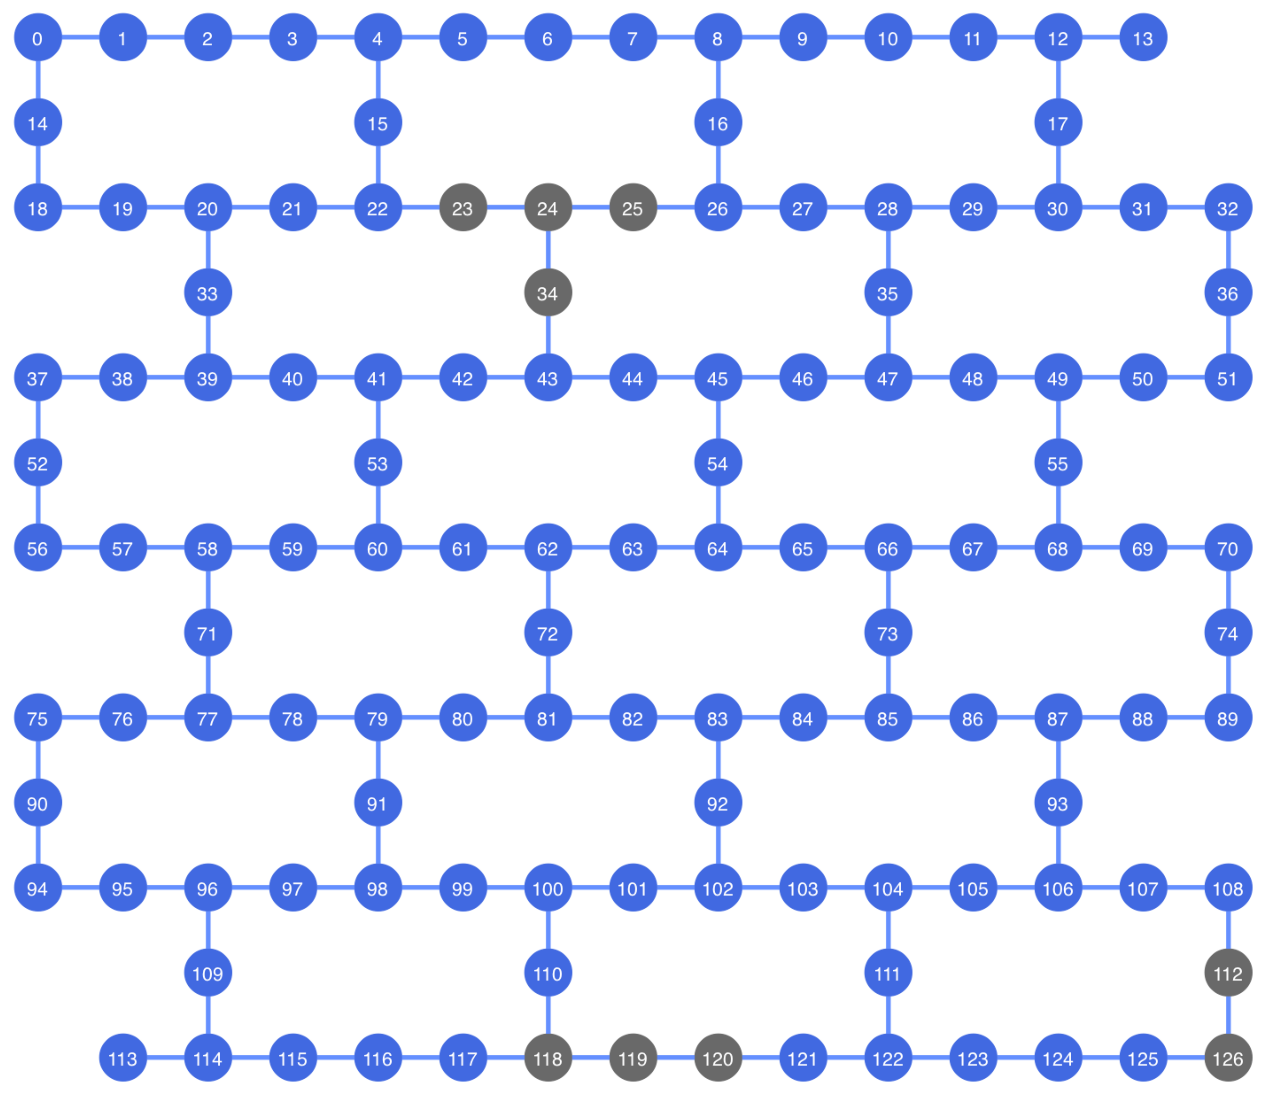

In [7]:
plot_coupling_map(
    num_qubits=num_nodes, 
    qubit_coordinates=eagle_qubit_coordinates(), 
    label_qubits=True, 
    coupling_map=eagle_coupling_map(), 
    qubit_color=eagle_qubit_color(eagle_qubit_labels(), bad_qubits),
    qubit_labels=eagle_qubit_labels(),
    font_size=16,
    qubit_size=48,
    # filename="eagle_ising_graph_118q.png",
)

In [7]:
# threshold for gate cutoff
threshold = 0.001
shots = 2 ** 13

service = QiskitRuntimeService(instance="client-enablement/its/its-skill-buildi")
layout = [i for i in range(num_nodes)]

backend = service.backend("ibm_brisbane")
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout=layout)

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian 
#### Without bias field
$$H_{ad} = (1 - \lambda) \sum_i h^x_i X_i + \lambda \left( \sum_i h^z_i Z_i + \sum_{i < j} J_{ij} Z_i Z_j \right)$$

#### With bias field
$$H_{ad} = (1 - \lambda) \sum_i (h^x_i X_i + h^b_i Z_i) + \lambda \left( \sum_i h^z_i Z_i + \sum_{i < j} J_{ij} Z_i Z_j \right)$$

#### With anti-bias field ($h^b_i \to - h^b_i$)
$$H_{ad} = (1 - \lambda) \sum_i (h^x_i X_i - h^b_i Z_i) + \lambda \left( \sum_i h^z_i Z_i + \sum_{i < j} J_{ij} Z_i Z_j \right)$$

## Counterdiabatic terms of Ising model Hamiltonian 
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$

## Time evolution operator
$$U(t) = \exp \left[- i \int^t_0 d \tau (H_{ad} + H_{cd}) \right]$$

## Results
### Bias-field

In [11]:
job = service.job("cv64e50fkm5g008byqa0")
result = job.result()
quasi_dist_iter_1 = result[0].data.meas.get_counts()

job = service.job("cv6nxcnkwkwg008t3mx0")
result = job.result()
quasi_dist_iter_3 = result[0].data.meas.get_counts()

job = service.job("cv79mzv4p20g008s0h70")
result = job.result()
quasi_dist_iter_5 = result[0].data.meas.get_counts()

job = service.job("cv8be9hkfn8g008vnxr0")
result = job.result()
quasi_dist_iter_7 = result[0].data.meas.get_counts()

job = service.job("cv8casvkfn8g008vnzk0")
result = job.result()
quasi_dist_iter_9 = result[0].data.meas.get_counts()

job = service.job("cv8ckfxqrk1g008r08mg")
result = job.result()
quasi_dist_iter_11 = result[0].data.meas.get_counts()

job = service.job("cv8ctwk8gpc0008gej1g")
result = job.result()
quasi_dist_iter_13 = result[0].data.meas.get_counts()

job = service.job("cv8d1dnqrk1g008r0930")
result = job.result()
quasi_dist_iter_15 = result[0].data.meas.get_counts()

job = service.job("cv8d84gqrk1g008r0980")
result = job.result()
quasi_dist_iter_17 = result[0].data.meas.get_counts()

In [12]:
minimum_objective_values = []

objective_iter_1 = []
for k, p in quasi_dist_iter_1.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_1.append(v)

minimum_objective_values.append(min(objective_iter_1))

objective_iter_3 = []
for k, p in quasi_dist_iter_3.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_3.append(v)

minimum_objective_values.append(min(objective_iter_3))

objective_iter_5 = []
for k, p in quasi_dist_iter_5.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_5.append(v)
    
minimum_objective_values.append(min(objective_iter_5))

objective_iter_7 = []
for k, p in quasi_dist_iter_7.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_7.append(v)

minimum_objective_values.append(min(objective_iter_7))

objective_iter_9 = []
for k, p in quasi_dist_iter_9.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_9.append(v)

minimum_objective_values.append(min(objective_iter_9))

objective_iter_11 = []
for k, p in quasi_dist_iter_11.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_11.append(v)

minimum_objective_values.append(min(objective_iter_11))

objective_iter_13 = []
for k, p in quasi_dist_iter_13.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_13.append(v)

minimum_objective_values.append(min(objective_iter_13))

objective_iter_15 = []
for k, p in quasi_dist_iter_15.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_15.append(v)

minimum_objective_values.append(min(objective_iter_15))

objective_iter_17 = []
for k, p in quasi_dist_iter_17.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_17.append(v)

minimum_objective_values.append(min(objective_iter_17))

print(minimum_objective_values)

[-103.57699791716631, -111.73030667387175, -112.79727791466735, -114.74287383388362, -103.99077092759146, -105.48136467136536, -112.50571563616353, -109.03785205275412, -111.99290165320102]


In [13]:
expectation_values = []

expectation_values.append(sampled_expectation_value(quasi_dist_iter_1, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_3, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_5, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_7, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_9, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_11, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_13, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_15, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_17, Hf))

print(expectation_values)

[-47.2921647676507, -58.76597870316762, -57.207485883102954, -59.06666149550848, -56.95060326032894, -58.43810369609516, -58.40024286874533, -57.858718791665346, -57.46203048326033]


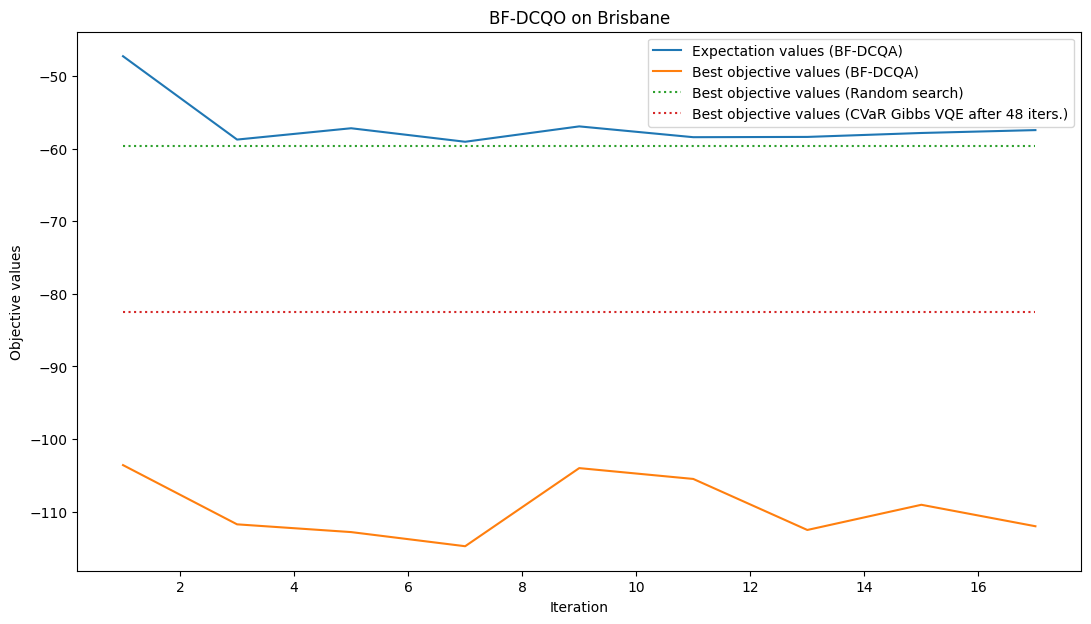

In [20]:
plt.figure(figsize=(1.85 * 7, 7))
x = [i for i in range(1, 18, 2)]
plt.plot(x, expectation_values)
plt.plot(x, minimum_objective_values)
plt.plot(x, [-59.614442272464245] * len(x), ":")
plt.plot(x, [-82.48935348682926] * len(x), ":")

# plt.xticks(rotation=90)
plt.xlabel("Iteration")
plt.ylabel("Objective values")
# plt.xlim(min(objective_2_steps) - 5, -60)
plt.title("BF-DCQO on Brisbane")
plt.legend([
    "Expectation values (BF-DCQA)", "Best objective values (BF-DCQA)",
    "Best objective values (Random search)", "Best objective values (CVaR Gibbs VQE after 48 iters.)",
])
plt.show()

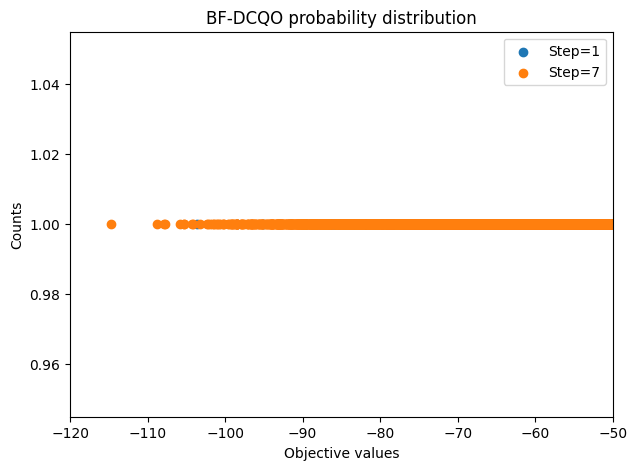

In [21]:
plt.figure(figsize=(7, 5))
plt.scatter(objective_iter_1, quasi_dist_iter_1.values())
plt.scatter(objective_iter_7, quasi_dist_iter_7.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Counts")
plt.xlim(-120, -50)
plt.title("BF-DCQO probability distribution")
plt.legend(["Step=1", "Step=7"])
plt.show()

### Anti-bias field ($h^b_i \to - h^b_i$)

In [22]:
job = service.job("cv64e50fkm5g008byqa0")
result = job.result()
quasi_dist_iter_1 = result[0].data.meas.get_counts()

job = service.job("cv6awgj39kwg008vvqbg")
result = job.result()
quasi_dist_iter_2 = result[0].data.meas.get_counts()

job = service.job("cv6nxcnkwkwg008t3mx0")
result = job.result()
quasi_dist_iter_3 = result[0].data.meas.get_counts()

job = service.job("cv705b5w1n800082vc10")
result = job.result()
quasi_dist_iter_4 = result[0].data.meas.get_counts()

job = service.job("cv79wbskwkwg008rkrz0")
result = job.result()
quasi_dist_iter_5 = result[0].data.meas.get_counts()

job = service.job("cv8bmtvkfn8g008vnyhg")
result = job.result()
quasi_dist_iter_6 = result[0].data.meas.get_counts()

job = service.job("cv8c0y3kfn8g008vnz30")
result = job.result()
quasi_dist_iter_7 = result[0].data.meas.get_counts()

In [23]:
minimum_objective_values = []

objective_iter_1 = []
for k, p in quasi_dist_iter_1.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_1.append(v)

minimum_objective_values.append(min(objective_iter_1))

objective_iter_2 = []
for k, p in quasi_dist_iter_2.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_2.append(v)

minimum_objective_values.append(min(objective_iter_2))

objective_iter_3 = []
for k, p in quasi_dist_iter_3.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_3.append(v)

minimum_objective_values.append(min(objective_iter_3))

objective_iter_4 = []
for k, p in quasi_dist_iter_4.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_4.append(v)

minimum_objective_values.append(min(objective_iter_4))

objective_iter_5 = []
for k, p in quasi_dist_iter_5.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_5.append(v)
    
minimum_objective_values.append(min(objective_iter_5))

objective_iter_6 = []
for k, p in quasi_dist_iter_6.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_6.append(v)

minimum_objective_values.append(min(objective_iter_6))

objective_iter_7 = []
for k, p in quasi_dist_iter_7.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_iter_7.append(v)

minimum_objective_values.append(min(objective_iter_7))

print(minimum_objective_values)

[-103.57699791716631, -105.76874183513794, -111.73030667387175, -106.59328270293145, -112.30995345418395, -112.2924022637682, -113.21612638645448]


In [24]:
expectation_values = []

expectation_values.append(sampled_expectation_value(quasi_dist_iter_1, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_2, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_3, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_4, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_5, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_6, Hf))
expectation_values.append(sampled_expectation_value(quasi_dist_iter_7, Hf))


print(expectation_values)

[-47.2921647676507, -57.945030700440945, -58.76597870316762, -55.417873761093816, -56.606711138245636, -60.149456262394494, -58.48154181150838]


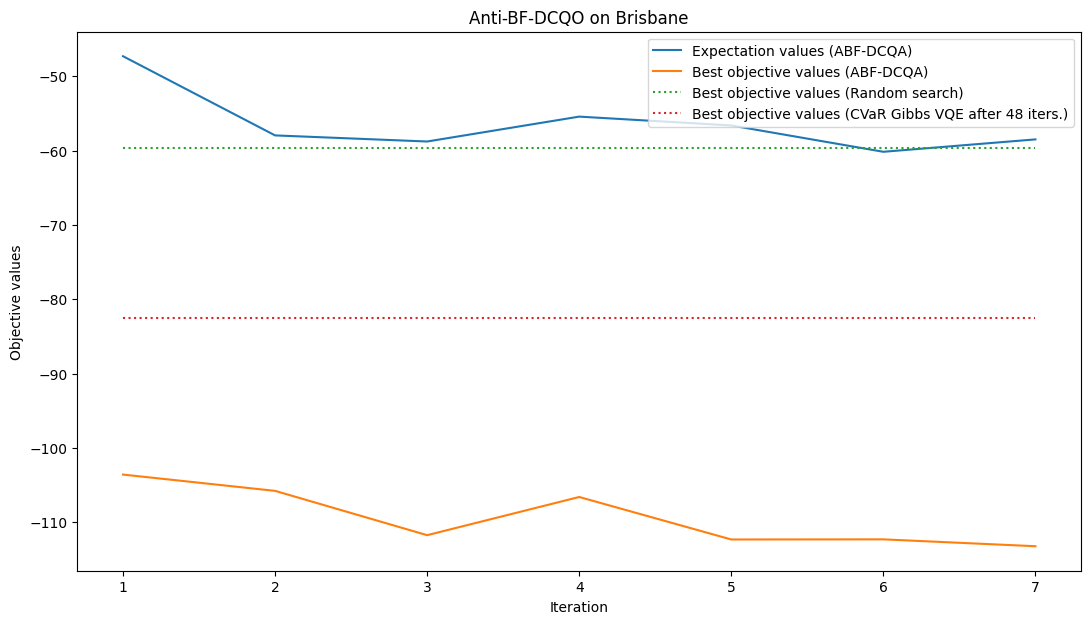

In [25]:
plt.figure(figsize=(1.85 * 7, 7))
x = [i for i in range(1, 8)]
plt.plot(x, expectation_values)
plt.plot(x, minimum_objective_values)
plt.plot(x, [-59.614442272464245] * len(x), ":")
plt.plot(x, [-82.48935348682926] * len(x), ":")

# plt.xticks(rotation=90)
plt.xlabel("Iteration")
plt.ylabel("Objective values")
# plt.xlim(min(objective_2_steps) - 5, -60)
plt.title("Anti-BF-DCQO on Brisbane")
plt.legend([
    "Expectation values (ABF-DCQA)", "Best objective values (ABF-DCQA)",
    "Best objective values (Random search)", "Best objective values (CVaR Gibbs VQE after 48 iters.)",
])
plt.show()

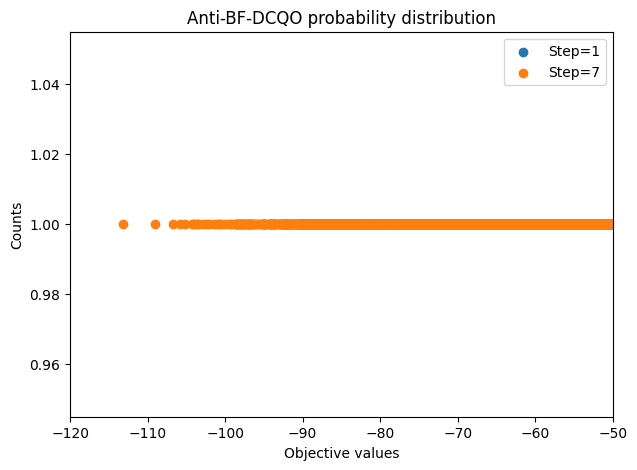

In [26]:
plt.figure(figsize=(7, 5))
plt.scatter(objective_iter_1, quasi_dist_iter_1.values())
plt.scatter(objective_iter_7, quasi_dist_iter_7.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Counts")
plt.xlim(-120, -50)
plt.title("Anti-BF-DCQO probability distribution")
plt.legend(["Step=1", "Step=7"])
plt.show()

## Appendix
### BF-DCQO circuit

In [8]:
# result from 1st iteration run
hb = np.array([0.027587890625, 0.353515625, -0.125732421875, 0.10498046875, 0.50634765625, 0.467041015625, -0.105712890625, 0.09033203125, 0.010498046875, 0.1748046875, -0.187744140625, -0.227783203125, 0.002685546875, -0.422119140625, -0.064208984375, 0.51171875, -0.00830078125, 0.26806640625, -0.17138671875, -0.02734375, -0.177978515625, 0.097412109375, -0.401611328125, -0.036865234375, -0.493896484375, -0.053955078125, 0.01953125, 0.103759765625, 0.010498046875, -0.06396484375, -0.21142578125, -0.24658203125, -0.2236328125, -0.51708984375, 0.003173828125, 0.074462890625, 0.197998046875, 0.3251953125, -0.262939453125, -0.461181640625, -0.09814453125, 0.150634765625, 0.287841796875, -0.17626953125, -0.176513671875, -0.19287109375, 0.217041015625, -0.052734375, -0.084716796875, -0.167236328125, -0.311767578125, -0.002685546875, -0.2978515625, 0.0771484375, -0.22216796875, -0.154296875, 0.398193359375, -0.04150390625, 0.1318359375, 0.06689453125, -0.033935546875, -0.10595703125, 0.336669921875, -0.216064453125, 0.248046875, -0.126953125, -0.070068359375, -0.03271484375, -0.130859375, -0.23681640625, 0.16357421875, 0.081787109375, -0.14404296875, 0.024169921875, 0.41552734375, 0.37939453125, 0.25244140625, -0.045166015625, -0.070068359375, -0.066162109375, 0.12109375, 0.100341796875, -0.19921875, 0.015869140625, -0.254150390625, 0.180908203125, 0.18017578125, 0.0517578125, 0.043701171875, -0.13232421875, 0.111083984375, 0.0205078125, -0.129150390625, -0.0595703125, -0.098388671875, -0.00048828125, 0.103271484375, 0.142822265625, 0.260009765625, 0.423583984375, 0.402587890625, 0.133544921875, 0.06103515625, 0.07861328125, -0.073486328125, -0.380615234375, 0.207275390625, -0.18310546875, 0.29150390625, 0.173095703125, 0.361328125, 0.18505859375, 0.148193359375, -0.190673828125, 0.156005859375, -0.09130859375, -0.185302734375, 0.203125, -0.010009765625, -0.010498046875, 0.00927734375, 0.264404296875, 0.2158203125, 0.16748046875, -0.05615234375, 0.056884765625, 0.012939453125])

T = 1
dt = 0.15
trotter_steps = [1, 2]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=hb)
C = eval_C(hx, hz, J2, hb=hb)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.007310038819959761, 0.10120449450040796]
[0.19084604805137834, 1.2040866472968799]
[-0.0738380898479515, -0.08995371621596886]
[0.028183415286288285, 0.21662413714076184]


In [11]:
phi = [gs_rotation_angle(hxi, hbi) for hxi, hbi in zip(hx, hb)]
circ = bf_dcqo_circ(num_nodes, phi, hx, hb, hz, row, col, J_data, y, dy, a1, threshold=threshold)
isa_circ = pm.run(circ)
isa_circ.draw("mpl", fold=-1, idle_wires=False)

### Classical random search result
- Best objective value: -59.614442272464245

### CVaR Gibbs VQE on MPS simulator
```
Date time: 20240828_1520 to 20240828_2200
number of params: 254
step 0 	     exp_evals 1 	 cvar -6.399 	 fval -59.61448851295748 	 best val -59.614442272464245
step 1 	     exp_evals 4 	 cvar -7.048 	 fval -63.95901044424515 	 best val -69.67962329514441
...
step 14 	 exp_evals 43 	 cvar -7.620 	 fval -55.04216122744814 	 best val -69.89042136325436
step 15 	 exp_evals 46 	 cvar -7.465 	 fval -75.60759505516081 	 best val -75.60754881466758
...
step 32 	 exp_evals 97 	 cvar -9.071 	 fval -72.53855615738377 	 best val -75.60754881466758
step 33 	 exp_evals 100 	 cvar -8.995 	 fval -82.48939972732249 	 best val -82.48935348682926
...
step 48 	 exp_evals 145 	 cvar -10.423 	 fval -66.10754903388057 	 best val -82.48935348682926
```